In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.special as sp
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedKFold

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.preprocessing import label_binarize
from itertools import cycle

/home/smaheshwari/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
clinical_all = pd.read_csv('./s_data/crc_clinical_sheet.txt', delimiter='\t')
meth = pd.read_csv('./s_data/crc_methylation_datamatrix.tsv', delimiter='\t')
meth = meth.T
meth.columns = meth.loc['Composite',:]
meth.drop(['Composite','Gene','Chr','Coordinate'], axis=0, inplace=True)

In [3]:
#DATA CLEANING

# drop coloumns & rows which have nan in more than 50% instances
meth = meth.dropna(axis=1, thresh = 0.5*meth.shape[0]) # for columns
meth = meth.dropna(axis=0, thresh = 0.5*meth.shape[1]) # for rows
meth_col = meth.columns.tolist()
meth_index = meth.index.tolist()

# Fill nan with the median values
fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
meth =  pd.DataFrame(fill_NaN.fit_transform(meth), index=meth_index)
meth.columns = meth_col

In [4]:
## DATA MUNGING

# convert beta-values to M-values usint logit transformation
# since logit(0) is minus infinity convert all beta values that are zero to 0.0001

meth_mval = meth.replace(0, 0.0001)
meth_mval = meth_mval.applymap(lambda x : sp.logit(x))

# scale the mvalues 
def featureScaling(x):
    ub = 4
    lb = -6
    x_scale = (x - lb) / (ub - lb)
    x_scale = 0 if x_scale < 0 else x_scale
    x_scale = 1 if x_scale > 1 else x_scale
    return float(x_scale)

meth_mval = meth_mval.applymap(lambda x: featureScaling(x))

meth_bval = meth.copy()

meth_bval['patient'] = meth_bval.index.tolist()
meth_bval['patient'] = meth_bval['patient'].apply(lambda x : x[0:12])

meth_mval['patient'] = meth_mval.index.tolist()
meth_mval['patient'] = meth_mval['patient'].apply(lambda x : x[0:12])

# Extract colon-cancer tumor site information 

location = clinical_all[['patient','tumor_site']]
location = location.dropna(axis=0)
location['class'] = location['tumor_site'].str.split('-').str[0].astype(np.int64)

# merge location and methylation data
crc_bval = pd.merge(location, meth_bval, on='patient', how='inner')
crc_mval = pd.merge(location, meth_mval, on='patient', how='inner')

crc_bval.drop(['patient','tumor_site'], axis=1, inplace=True)
crc_mval.drop(['patient','tumor_site'], axis=1, inplace=True)

colon_mval = crc_mval[crc_mval['class'] != 4]
colon_bval = crc_bval[crc_bval['class'] != 4]

In [5]:
def convert_file2list(filename):
    input_file = open(filename,'r')
    lines1 = input_file.read().splitlines()
    input_file.close()
    out_list  = [line.rstrip('\n') for line in lines1]
    return (out_list)

In [6]:
list_delta = convert_file2list('./s_lists/DMG_delta0.28_cpg.lst')
cpg_features = list(set(list_delta) & set(meth_col))

In [7]:
X = colon_mval[cpg_features]
X = X.values

y = colon_mval['class']
y = y.values

no_class = len(colon_mval['class'].unique().tolist())
classes = sorted(colon_mval['class'].unique().tolist())

# Binarize the output
y = label_binarize(y, classes=classes)
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

# Learn to predict each class against the other
random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [8]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in classes:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, (i-1)], y_score[:, (i-1)])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [9]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

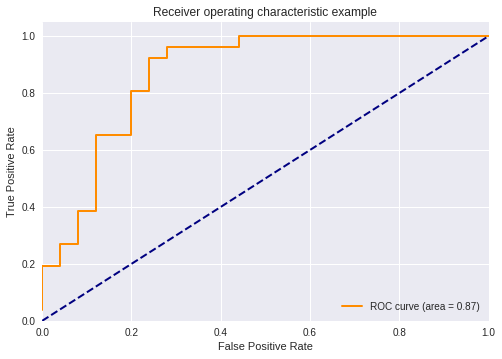

In [10]:
# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

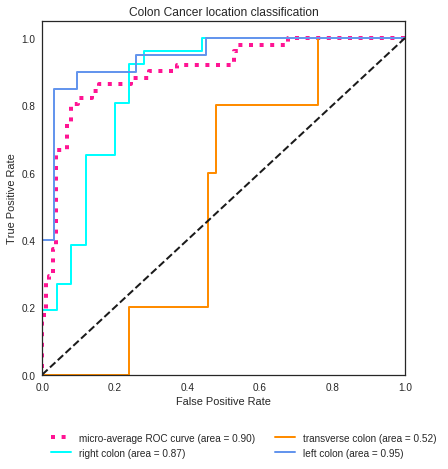

In [11]:
import matplotlib as mpl
#mpl.style.use('classic')
sns.set(style="white", color_codes=True)
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in classes:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves

plt.figure(figsize=(6.5,6.5), facecolor='white')

plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'
#         ''.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
dict_location = {1:'right colon',2:'transverse colon',3:'left colon',4:'rectum'}
for i, color in zip(classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(dict_location[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Colon Cancer location classification')
## plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(0, -0.2), loc='center left', ncol=2)
plt.savefig('./s_figures/ROCplot_3class_93features.png',dpi=300,bbox_inches='tight')
plt.show()

In [56]:
len(meth_col)

23094

In [53]:
def roc_curve(df, features ,c_val=None):
    df = colon_mval.copy()
    X = df[cpg_features]
    X = X.values
    y = df['class']
    y=y.values
    no_class = len(df['class'].unique().tolist())
    classes = sorted(df['class'].unique().tolist())
    
    # Binarize the output
    y = label_binarize(y, classes=classes)
    n_classes = y.shape[1]

    c_val = 1 if c_val is 'None' else c_val

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, stratify =y)

    # Learn to predict each class against the other
    random_state = np.random.RandomState(0)
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, (i-1)], y_score[:, (i-1)])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

    lw = 2
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in classes:
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves

    plt.figure(figsize=(6.5,6.5), facecolor='white')

    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)

    #plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'
    #         ''.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    dict_location = {1:'right colon',2:'transverse colon',3:'left colon',4:'rectum'}
    for i, color in zip(classes, colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='{0} (area = {1:0.2f})'
                 ''.format(dict_location[i], roc_auc[i]))


    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Colon Cancer location classification')
    ## plt.legend(loc="lower right")
    plt.legend(bbox_to_anchor=(0, -0.2), loc='center left', ncol=2)
    plt.savefig('./s_figures/ROCplot_3class.png',dpi=300,bbox_inches='tight')
    plt.show()    
    
    return

In [54]:
roc_curve(colon_mval, cpg_features,1)

RuntimeError: maximum recursion depth exceeded in cmp